<a href="https://colab.research.google.com/github/YazCodes/TimeSeriesAI/blob/main/Applied_AI_Time_Series_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applied AI: Time Series Notebook
This notebook contains the practical examples and exercises for the Applied AI module. Created by Iain Rice

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
#from quantecon import Kalman, LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from numpy import dot
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Stationarity

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)



Result: The series is not stationary



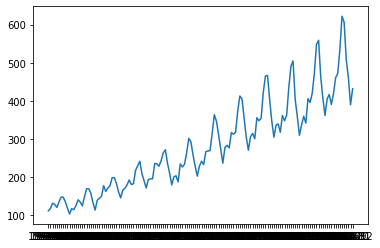

,Month,Sales
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df = pd.read_csv('international-airline-passengers 2.csv')
df = df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Sales"}) #renaming the coloumn 

statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['Sales']) 
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(df['Month'],df['Sales'])
plt.show()
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)



Result: The series is not stationary



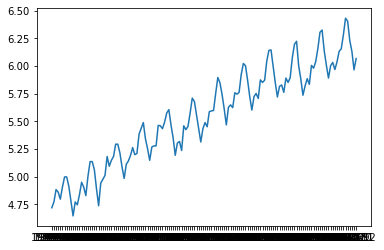

,Month,Sales,stationary
0,1949-01,112,4.718499
1,1949-02,118,4.770685
2,1949-03,132,4.882802
3,1949-04,129,4.859812
4,1949-05,121,4.795791


In [ ]:
df['stationary'] = np.log(df['Sales']) # get rid of peaks and troffs using the log function, create a new column called stationary

statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary'])
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(df['Month'],df['stationary'])
plt.show()
df.head()

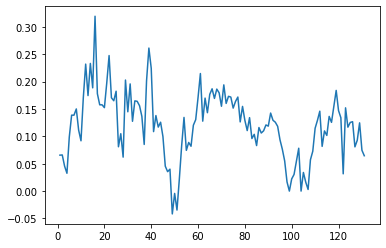

,Sales,stationary
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [ ]:
mons = df.pop('Month')  #The differencing aspect, have to remove the months, python can not take away string values
u = df.iloc[1]['stationary']
df=df.diff(axis=0,periods=12) #takes row 13 away from row 1 

plt.plot(np.linspace(1,131,131),df['stationary'][13:])#rows 1-12 are empty values as there were less than month 12 therfore going from row 13 now
plt.show()
df.head()


Result: The series is stationary



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


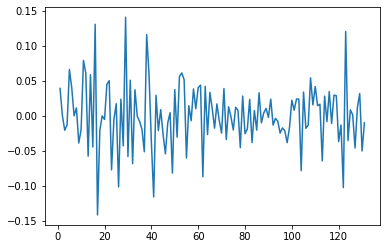

,Sales,stationary
139,-27.0,-0.045934
140,-2.0,0.012024
141,9.0,0.031830
142,-26.0,-0.050082
143,-1.0,-0.009964


In [ ]:
u = df.iloc[13]['stationary'] #one more diffrence to make it stationary 
df = df.diff(axis=0) #df.diff automatically does the diffrence one moth before hand 

statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary'])
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(np.linspace(1,131,131),df['stationary'][13:])
plt.show()
df.tail()

In [ ]:
statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary'])
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')


Result: The series is stationary



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


#ARIMA

In [ ]:
data = sm.datasets.co2.load_pandas()
data.data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)



Result: The series is not stationary



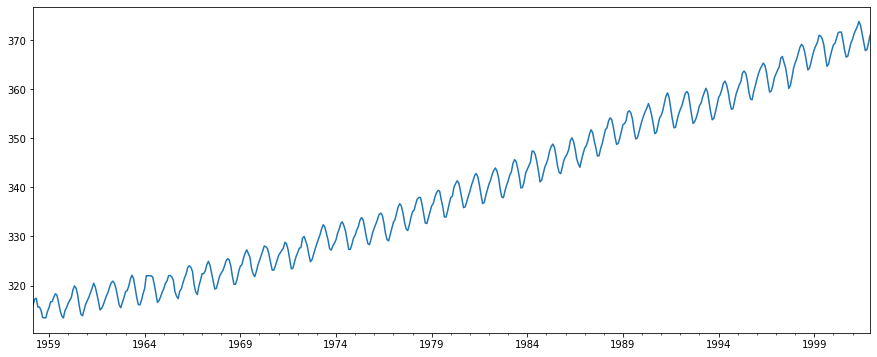

In [ ]:
y = data.data
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))

# check if the TS is stationary
statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(y)
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

In [ ]:
import itertools
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912957195
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912989044791
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:700.9035674463718
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:323.0776499906083
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5190004031109
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:279.8705604004679
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:781.4979258153785
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:332.5321367824651
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:290.7189960700617
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:329.58449600585243
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:284.3597276913723


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:282.9994168282969
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:293.7426223856211
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.78021776587207
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:279.5125527048292
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:572.1786409500489
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:303.9905354135731
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:286.0729524972156
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:293.8643463501482
ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:279.4441106059478
ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:281.10448629667854
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:288.96467851263367
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:281.6328375531698
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:281.4718814653469
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:501.1094516370025
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:297.09272880803144


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:288.33297022461073


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.811      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


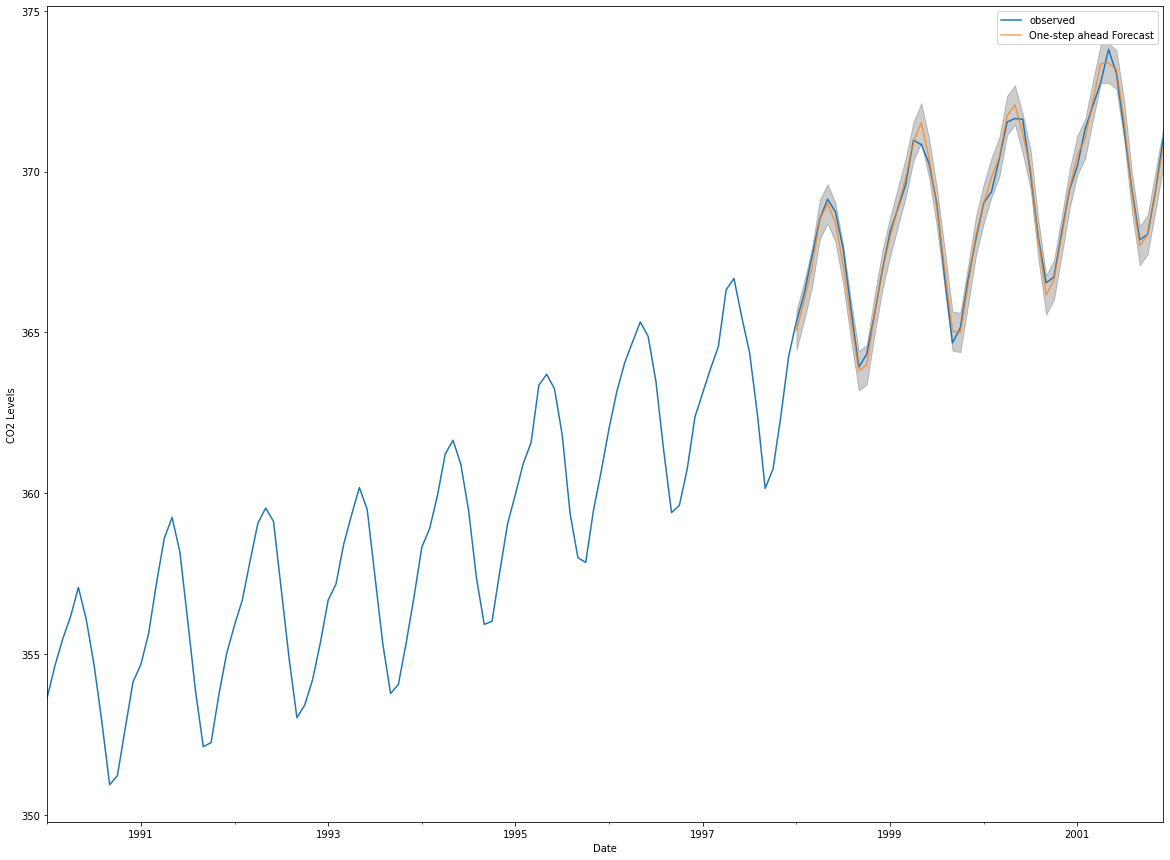

The Mean Squared Error of our forecasts is 0.07


In [ ]:
# specify model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# fit model
results = mod.fit()
print(results.summary().tables[1])
# make predictions
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

# plotting code
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#Exponential Smoothing

In [ ]:
df = pd.read_csv('HPI_master.csv')
df["time"] = df["yr"].astype(str) + "_" + df["period"].astype(str)
df = df.drop(["yr","period"],axis=1)
df.tail()

,index_nsa,time
353,245.83,2020_6
354,249.32,2020_7
355,251.67,2020_8
356,254.20,2020_9
357,256.40,2020_10


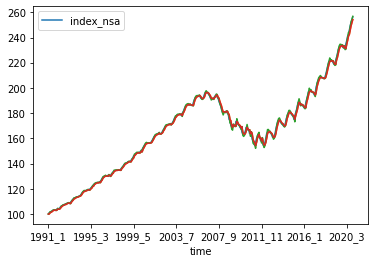

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
results1 = SimpleExpSmoothing(df["index_nsa"]).fit()
results2 = Holt(df["index_nsa"]).fit()
results3 = ExponentialSmoothing(df["index_nsa"]).fit()

df.plot.line(x = 'time', 
             y = 'index_nsa')
plt.plot(df["time"],results1.fittedvalues)
plt.plot(df["time"],results2.fittedvalues)
plt.plot(df["time"],results3.fittedvalues)
import matplotlib
matplotlib.rc('figure', figsize=(30, 10))
plt.show()


#Embedding

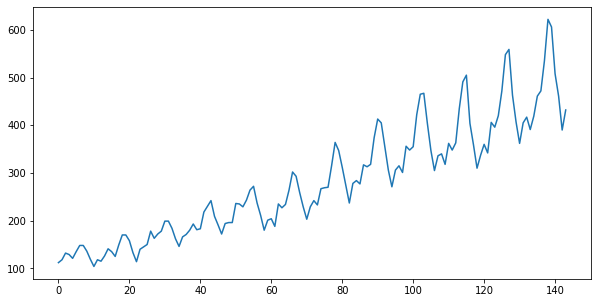

In [ ]:
matplotlib.rc('figure', figsize=(10, 5))
df = pd.read_csv('international-airline-passengers 2.csv')
x = df['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'].to_numpy()
plt.plot(x)
plt.show()


In [ ]:
print("Shape of data:")
print(x.shape)

print("\nStacked data with delay embedding 2:")
X = np.vstack((x[:-1],x[1:])).T
print(X[:5,:])

print("\nStacked data with delay embedding 3:")
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print(X[:5,:])

Shape of data:
(144,)

Stacked data with delay embedding 2:
[[112 118]
 [118 132]
 [132 129]
 [129 121]
 [121 135]]

Stacked data with delay embedding 3:
[[112 118 132]
 [118 132 129]
 [132 129 121]
 [129 121 135]
 [121 135 148]]


In [ ]:
u,s,v = np.linalg.svd(X)
print("Relative importance of each dimension for an order 3 delay embedding:")
print(s/max(s))

print("Relative importance of each dimension for an order 4 delay embedding:")
X = np.vstack((x[:-3],x[1:-2],x[2:-1],x[3:])).T
u,s,v = np.linalg.svd(X)
print(s/max(s))

print("Relative importance of each dimension for an order 5 delay embedding:")
X = np.vstack((x[:-4],x[1:-3],x[2:-2],x[3:-1],x[4:])).T
u,s,v = np.linalg.svd(X)
print(s/max(s))

print("Relative importance of each dimension for an order 6 delay embedding:")
X = np.vstack((x[:-5],x[1:-4],x[2:-3],x[3:-2],x[4:-1],x[5:])).T
u,s,v = np.linalg.svd(X)
print(s/max(s))

Relative importance of each dimension for an order 3 delay embedding:
[1.         0.07314624 0.03079164]
Relative importance of each dimension for an order 4 delay embedding:
[1.         0.08563985 0.04097847 0.02113348]
Relative importance of each dimension for an order 5 delay embedding:
[1.         0.09365044 0.05068503 0.02562099 0.01767495]
Relative importance of each dimension for an order 6 delay embedding:
[1.         0.09720604 0.05926447 0.02955839 0.02112643 0.01479424]


So approximately 2 of singular values contain 95% of the relative importance. So we should embed this data in a 2(2)+1 = 5 dimensional space to model it accurately. Note that this would typically be done AFTER the data has been made stationary.


#Lorenz Method of Analogues & Data Pre-processing / Wrangling
Example with City Temperatures Dataset. Need to do some data pre-processing and wrangling first.

This has been a really simple example. Now we're going to move on to looking at data exploration, for which we need a more complex dataset. We're going to be looking at recorded measurements of city temperatures. Datacentres are now predominantly built in cold climates as it costs less for the servers to be cooled. Producing long-lasting strong alcohol in equatorial climates is extemely difficult. Manufacturing by necessity means you need to understand the climate within which you are operating. As before, let's start by loading in the data.

In [ ]:
data = pd.read_csv("city_temperature.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To start with, look at part of the data and describe it to get a feel for the headings and information contained within the dataframe. Then we need to check if there are any null values:

In [ ]:
data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [ ]:
data.describe()

,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [ ]:
data.isna().any()

Region            False
Country           False
State              True
City              False
Month             False
Day               False
Year              False
AvgTemperature    False
dtype: bool

In [ ]:
# Let's see what the regions are in the dataframe:
data.Region.unique()

array(['Africa', 'Asia', 'Australia/South Pacific', 'Europe',
       'Middle East', 'North America',
       'South/Central America & Carribean'], dtype=object)

In [ ]:
# So the temperatures are stored in farenheight and as a more modern group we want to work with celsius, so let's use a function to transform the data:
def to_celsius(row):
    return round((row-32) * (5/9),1)

data['AvgTemperature'] = data['AvgTemperature'].apply(to_celsius)

In [ ]:
data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,17.9
1,Africa,Algeria,NaN,Algiers,1,2,1995,9.7
2,Africa,Algeria,NaN,Algiers,1,3,1995,9.3
3,Africa,Algeria,NaN,Algiers,1,4,1995,8.0
4,Africa,Algeria,NaN,Algiers,1,5,1995,8.8


We can get a summary of what's going on within a dataset by grouping subcategories together, for instance getting the averages of the dataframe for each Region-Country-State-City and Year:

In [ ]:
data.groupby(['Region','Country','State','City','Year']).mean()

Month  ...  AvgTemperature
Region        Country State                  City                 Year            ...                
North America US      Additional Territories San Juan Puerto Rico 1995  6.526027  ...       27.008493
                                                                  1996  6.513661  ...      -15.196721
                                                                  1997  6.526027  ...       15.360548
                                                                  1998  6.526027  ...       11.422466
                                                                  1999  6.526027  ...       16.188767
...                                                                          ...  ...             ...
                      Wyoming                Cheyenne             2016  6.513661  ...        9.178689
                                                                  2017  6.526027  ...        9.107397
                                                                  2018  6.526027  ...        8.496164
                                                                  2019  6.526027  ...        7.590959
                                                                  2020  2.738806  ...        1.961940

[4031 rows x 3 columns]

Sometimes we know what city we want information for so can get a *slice* of the dataframe for subsequent plotting and analysis. Let's focus in on Vienna and look at the annual average temperatures.

In [ ]:
vienna = data[data['City']=='Vienna'].copy() # great city
vienna = vienna.groupby(['Year']).mean()
vienna.drop(columns=['Month','Day']).head()

,AvgTemperature
Year,
1995,10.137260
1996,8.710109
1997,9.825479
1998,9.827671
1999,10.301096


This is all well, but let's see a plot to get a really good idea of what's gone on here:

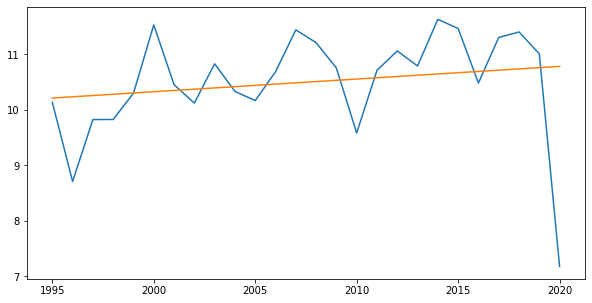

In [ ]:
# Plotting a line chart
plt.plot(vienna.index,vienna['AvgTemperature']) 

# fit a linear regression (trend)
m, b = np.polyfit(vienna.index, vienna['AvgTemperature'], 1)
plt.plot(vienna.index, m * vienna.index + b)

So here we've got an idea of what's going on, but there's a significant drop in 2020. What could be causing this? Let's explore and see the values for each year to check that 2020 is plotting correctly. Then let's view the *time series* for 2018-2020 and see what's going on with the trend.

In [ ]:
vienna.tail()

,Month,Day,AvgTemperature
Year,,,
2016,6.513661,15.756831,10.484699
2017,6.526027,15.720548,11.304384
2018,6.526027,15.720548,11.404384
2019,6.526027,15.720548,11.010959
2020,2.738806,14.798507,7.178358


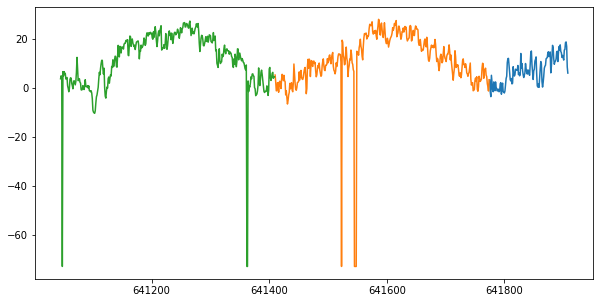

In [ ]:
sliced = data[data['City']=='Vienna']
sliced = sliced[sliced['Year']==2020]
plt.plot(sliced.index,sliced['AvgTemperature'])
sliced = data[data['City']=='Vienna']
sliced = sliced[sliced['Year']==2019]
plt.plot(sliced.index,sliced['AvgTemperature']) 
sliced = data[data['City']=='Vienna']
sliced = sliced[sliced['Year']==2018]
plt.plot(sliced.index,sliced['AvgTemperature']) 

So we should notice why 2020 is looking different on the averages listed above from this plot. What this has also highlighted is the fact that there are some uncharacteristically low values in 2018 and 2019. This data may actually need *cleaning* to avoid undue effects on subsequent modelling.

In [ ]:
print("Number of null values:")
print(sum(sliced['AvgTemperature'].isnull()))
print("Number of N\A values:")
print(sum(sliced['AvgTemperature'].isna()))
print("Number of low values (<20):")
print(sum(sliced['AvgTemperature']<-20))

Number of null values:
0
Number of N\A values:
0
Number of low values (<20):
3


Let's look into these 3 values in more detail:

In [ ]:
sliced[sliced['AvgTemperature']<-20].index

Int64Index([641048, 641362, 641363], dtype='int64')

In [ ]:
print(sliced.loc[[641048,641362,641363]])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641048  Europe  Austria   NaN  Vienna      1    4  2018           -72.8
641362  Europe  Austria   NaN  Vienna     11   14  2018           -72.8
641363  Europe  Austria   NaN  Vienna     11   15  2018           -72.8


So there is clearly values included here in error since Vienna didn't have -72.8 Celsius weather on these three days. We have a few options here to *clean* this bad data:

i)  We can cut it from the dataframe

ii) We can *impute* it

In [ ]:
# Let's drop the first one from the dataset and see what it looks like now:
sliced = sliced.drop(index=641048)

Now let's look at the next pair. We can swap these values for the mean of the data either side, or the median  of the year.

In [ ]:
print(sliced.loc[[641360,641361,641362,641363,641364,641365]])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641360  Europe  Austria   NaN  Vienna     11   12  2018             7.3
641361  Europe  Austria   NaN  Vienna     11   13  2018             9.3
641362  Europe  Austria   NaN  Vienna     11   14  2018           -72.8
641363  Europe  Austria   NaN  Vienna     11   15  2018           -72.8
641364  Europe  Austria   NaN  Vienna     11   16  2018             2.8
641365  Europe  Austria   NaN  Vienna     11   17  2018            -1.5


In [ ]:
sliced.at[641362,'AvgTemperature'] = 0.5*(sliced.at[641361,'AvgTemperature'] + sliced.at[641364,'AvgTemperature'])

In [ ]:
print(sliced.loc[[641360,641361,641362,641363,641364,641365]])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641360  Europe  Austria   NaN  Vienna     11   12  2018            7.30
641361  Europe  Austria   NaN  Vienna     11   13  2018            9.30
641362  Europe  Austria   NaN  Vienna     11   14  2018            6.05
641363  Europe  Austria   NaN  Vienna     11   15  2018          -72.80
641364  Europe  Austria   NaN  Vienna     11   16  2018            2.80
641365  Europe  Austria   NaN  Vienna     11   17  2018           -1.50


In [ ]:
sliced.at[641363,'AvgTemperature'] = sliced.loc[641355:641361,"AvgTemperature"].median()

In [ ]:
print(sliced.loc[[641360,641361,641362,641363,641364,641365]])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641360  Europe  Austria   NaN  Vienna     11   12  2018            7.30
641361  Europe  Austria   NaN  Vienna     11   13  2018            9.30
641362  Europe  Austria   NaN  Vienna     11   14  2018            6.05
641363  Europe  Austria   NaN  Vienna     11   15  2018            9.30
641364  Europe  Austria   NaN  Vienna     11   16  2018            2.80
641365  Europe  Austria   NaN  Vienna     11   17  2018           -1.50


So now we've dropped one from the dataset, replaced another with the mean of surrounding points and the other with the median. We'll look more into what the difference in these statistics can be later on. For now, let's look at the updated plot.

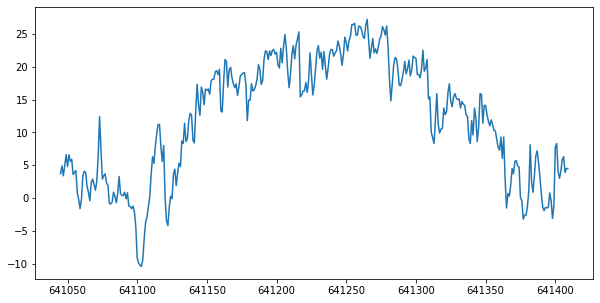

In [ ]:
plt.plot(sliced.index,sliced['AvgTemperature'])

In [ ]:
# Time series modelling
x = sliced['AvgTemperature'].to_numpy()
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print("\nStacked data with delay embedding 3:")
history = X[:250,:]
print(history[-5:,:])
print("\nTarget to predict:")
test = x[253]
print(test)
latest = np.reshape(X[250,:],(-1,3))
print("\n Latest observation:")
print(latest)


Stacked data with delay embedding 3:
[[19.2 20.8 18.9]
 [20.8 18.9 19.7]
 [18.9 19.7 21. ]
 [19.7 21.  18.6]
 [21.  18.6 19.5]]

Target to predict:
21.4

 Latest observation:
[[18.6 19.5 21.6]]


In [ ]:
# find data like most recent observation:
from scipy.spatial.distance import cdist
z = cdist(history,latest)
zz = np.argsort(z,axis=0)
print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

Five nearest neighbors from history:
[[18.1 19.8 21.9]
 [18.9 19.7 21. ]
 [18.  19.2 20.8]
 [17.3 20.2 21.4]
 [17.1 19.8 22.4]]


In [ ]:
# Standard prediction:
pred = x[zz[0,0]+3]
print("Standard prediction:")
print(pred)

print("\nAveraged prediction:")
neighbours = 5 # 7 gives good performance in this case
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+3])
print(pred2)

Standard prediction:
22.6

Averaged prediction:
20.900000000000002


#Kalman Filter
###example 1

###example 2

## The Basic Idea

The Kalman filter has many applications in economics, but for now
let’s pretend that we are rocket scientists.

A missile has been launched from country Y and our mission is to track it.

Let $ x  \in \mathbb{R}^2 $ denote the current location of the missile—a
pair indicating latitude-longitude coordinates on a map.

At the present moment in time, the precise location $ x $ is unknown, but
we do have some beliefs about $ x $.

One way to summarize our knowledge is a point prediction $ \hat x $

- But what if the President wants to know the probability that the missile is currently over the Sea of Japan?  
- Then it is better to summarize our initial beliefs with a bivariate probability density $ p $  
  
  - $ \int_E p(x)dx $ indicates the probability that we attach to the missile being in region $ E $.  
  


The density $ p $ is called our *prior* for the random variable $ x $.

To keep things tractable in our example,  we  assume that our prior is Gaussian.

In particular, we take


<a id='equation-prior'></a>
$$
p = N(\hat x, \Sigma) \tag{1}
$$

where $ \hat x $ is the mean of the distribution and $ \Sigma $ is a
$ 2 \times 2 $ covariance matrix.  In our simulations, we will suppose that


<a id='equation-kalman-dhxs'></a>
$$
\hat x
= \left(
\begin{array}{c}
    0.2 \\
    -0.2
\end{array}
  \right),
\qquad
\Sigma
= \left(
\begin{array}{cc}
    0.4 & 0.3 \\
    0.3 & 0.45
\end{array}
  \right) \tag{2}
$$

This density $ p(x) $ is shown below as a contour map, with the center of the red ellipse being equal to $ \hat x $.

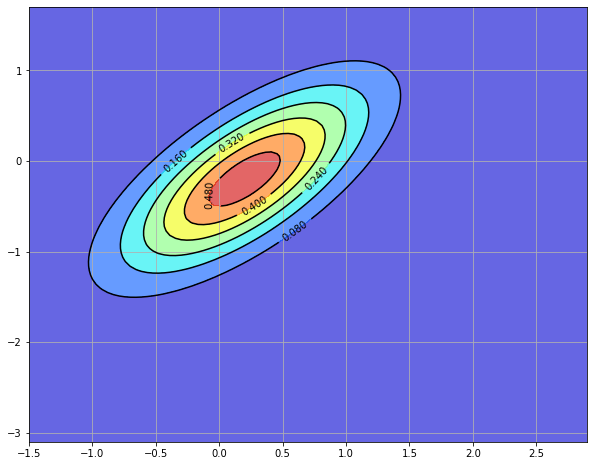

In [ ]:
# Set up the Gaussian prior density p
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T
# Define the matrices G and R from the equation y = G x + N(0, R)
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ
# The matrices A and Q
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.1 * Σ
# The observed value of y
y = np.matrix([2.3, -1.9]).T
# updated y
new_y = np.matrix([1.8, -0.6]).T

# Set up grid for plotting
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def bivariate_normal(x, y, σ_x=1.0, σ_y=1.0, μ_x=0.0, μ_y=0.0, σ_xy=0.0):
    """
    Compute and return the probability density function of bivariate normal
    distribution of normal random variables x and y

    Parameters
    ----------
    x : array_like(float)
        Random variable

    y : array_like(float)
        Random variable

    σ_x : array_like(float)
          Standard deviation of random variable x

    σ_y : array_like(float)
          Standard deviation of random variable y

    μ_x : scalar(float)
          Mean value of random variable x

    μ_y : scalar(float)
          Mean value of random variable y

    σ_xy : array_like(float)
           Covariance of random variables x and y

    """

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)
    return np.exp(-z / (2 * (1 - ρ**2))) / denom

def gen_gaussian_plot_vals(μ, C):
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y = np.sqrt(C[0, 0]), np.sqrt(C[1, 1])
    s_xy = C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

# Plot the figure

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)

plt.show()

### The Filtering Step

We are now presented with some good news and some bad news.

The good news is that the missile has been located by our sensors, which report that the current location is $ y = (2.3, -1.9) $.

The next figure shows the original prior $ p(x) $ and the new reported
location $ y $

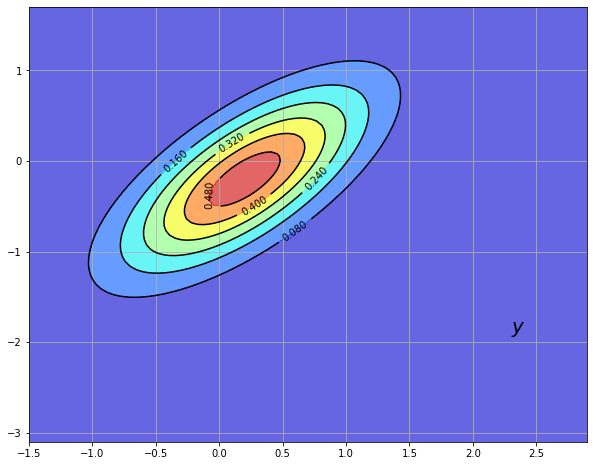

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

The bad news is that our sensors are imprecise.

In particular, we should interpret the output of our sensor not as
$ y=x $, but rather as


<a id='equation-kl-measurement-model'></a>
$$
y = G x + v, \quad \text{where} \quad v \sim N(0, R) \tag{3}
$$

Here $ G $ and $ R $ are $ 2 \times 2 $ matrices with $ R $
positive definite.  Both are assumed known, and the noise term $ v $ is assumed
to be independent of $ x $.

How then should we combine our prior $ p(x) = N(\hat x, \Sigma) $ and this
new information $ y $ to improve our understanding of the location of the
missile?

As you may have guessed, the answer is to use Bayes’ theorem, which tells
us to  update our prior $ p(x) $ to $ p(x \,|\, y) $ via

$$
p(x \,|\, y) = \frac{p(y \,|\, x) \, p(x)} {p(y)}
$$

where $ p(y) = \int p(y \,|\, x) \, p(x) dx $.

In solving for $ p(x \,|\, y) $, we observe that

- $ p(x) = N(\hat x, \Sigma) $.  
- In view of [(3)](#equation-kl-measurement-model), the conditional density $ p(y \,|\, x) $ is $ N(Gx, R) $.  
- $ p(y) $ does not depend on $ x $, and enters into the calculations only as a normalizing constant.  


Because we are in a linear and Gaussian framework, the updated density can be computed by calculating population linear regressions.

In particular, the solution is known <sup><a href=#f1 id=f1-link>[1]</a></sup> to be

$$
p(x \,|\, y) = N(\hat x^F, \Sigma^F)
$$

where


<a id='equation-kl-filter-exp'></a>
$$
\hat x^F := \hat x + \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
\quad \text{and} \quad
\Sigma^F := \Sigma - \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma \tag{4}
$$

Here  $ \Sigma G' (G \Sigma G' + R)^{-1} $ is the matrix of population regression coefficients of the hidden object $ x - \hat x $ on the surprise $ y - G \hat x $.

This new density $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is shown in the next figure via contour lines and the color map.

The original density is left in as contour lines for comparison

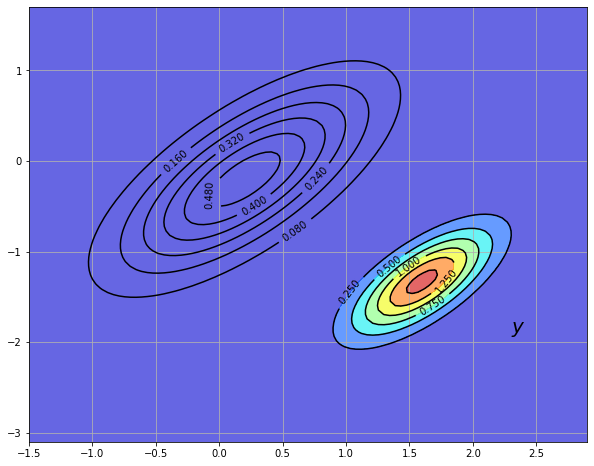

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

### The Forecast Step

What have we achieved so far?

We have obtained probabilities for the current location of the state (missile) given prior and current information.

This is called “filtering” rather than forecasting because we are filtering
out noise rather than looking into the future.

- $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is called the *filtering distribution*  


But now let’s suppose that we are given another task: to predict the location of the missile after one unit of time (whatever that may be) has elapsed.

To do this we need a model of how the state evolves.

Let’s suppose that we have one, and that it’s linear and Gaussian. In particular,


<a id='equation-kl-xdynam'></a>
$$
x_{t+1} = A x_t + w_{t+1}, \quad \text{where} \quad w_t \sim N(0, Q) \tag{5}
$$

Our aim is to combine this law of motion and our current distribution $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ to come up with a new *predictive* distribution for the location in one unit of time.

In view of [(5)](#equation-kl-xdynam), all we have to do is introduce a random vector $ x^F \sim N(\hat x^F, \Sigma^F) $ and work out the distribution of $ A x^F + w $ where $ w $ is independent of $ x^F $ and has distribution $ N(0, Q) $.

Since linear combinations of Gaussians are Gaussian, $ A x^F + w $ is Gaussian.

Elementary calculations and the expressions in [(4)](#equation-kl-filter-exp) tell us that

$$
\mathbb{E} [A x^F + w]
= A \mathbb{E} x^F + \mathbb{E} w
= A \hat x^F
= A \hat x + A \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
$$

and

$$
\operatorname{Var} [A x^F + w]
= A \operatorname{Var}[x^F] A' + Q
= A \Sigma^F A' + Q
= A \Sigma A' - A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q
$$

The matrix $ A \Sigma G' (G \Sigma G' + R)^{-1} $ is often written as
$ K_{\Sigma} $ and called the *Kalman gain*.

- The subscript $ \Sigma $ has been added to remind us that  $ K_{\Sigma} $ depends on $ \Sigma $, but not $ y $ or $ \hat x $.  


Using this notation, we can summarize our results as follows.

Our updated prediction is the density $ N(\hat x_{new}, \Sigma_{new}) $ where


<a id='equation-kl-mlom0'></a>
$$
\begin{aligned}
    \hat x_{new} &:= A \hat x + K_{\Sigma} (y - G \hat x) \\
    \Sigma_{new} &:= A \Sigma A' - K_{\Sigma} G \Sigma A' + Q \nonumber
\end{aligned} \tag{6}
$$

- The density $ p_{new}(x) = N(\hat x_{new}, \Sigma_{new}) $ is called the *predictive distribution*  


The predictive distribution is the new density shown in the following figure, where
the update has used parameters.

$$
A
= \left(
\begin{array}{cc}
    1.2 & 0.0 \\
    0.0 & -0.2
\end{array}
  \right),
  \qquad
Q = 0.3 * \Sigma
$$

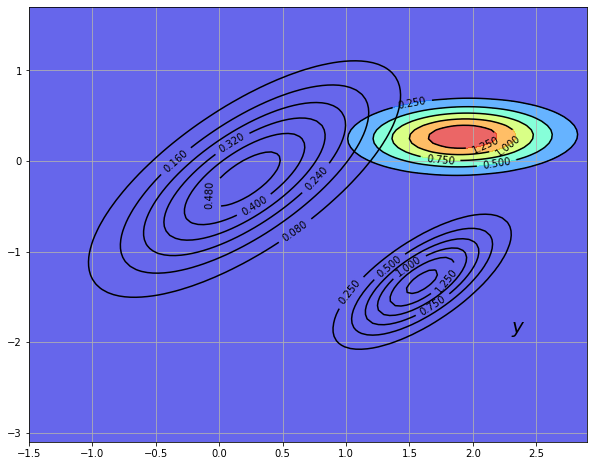

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

Now we get another measurement with y now being at (1.8,-0.6) so we need to do another update and prediction step.

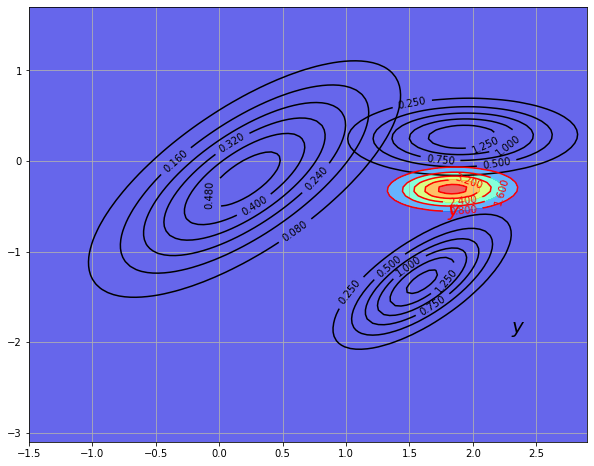

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

# Density 4
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
new_x_hat_F = new_x_hat + M * (new_y - G * new_x_hat)
new_Σ_F = new_Σ - M * G * new_Σ
new_Z_F = gen_gaussian_plot_vals(new_x_hat_F, new_Σ_F)
cs4 = ax.contour(X, Y, new_Z_F, 6, colors="red")
ax.clabel(cs4, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z_F, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")

plt.show()

The filtered update is much closer to the new y measurement (shown in red). We just need to take account of our expected dynamics to predict where it's going next.

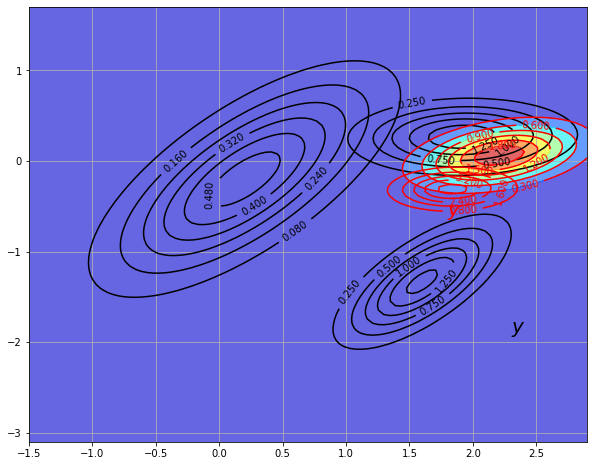

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

# Density 4
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
new_x_hat_F = new_x_hat + M * (new_y - G * new_x_hat)
new_Σ_F = new_Σ - M * G * new_Σ
new_Z_F = gen_gaussian_plot_vals(new_x_hat_F, new_Σ_F)
cs4 = ax.contour(X, Y, new_Z_F, 6, colors="red")
ax.clabel(cs4, inline=1, fontsize=10)
ax.text(float(new_y[0]), float(new_y[1]), "$y$", fontsize=20, color="red")

# Density 5
new_new_x_hat = A * new_x_hat_F
new_new_Σ = A * new_Σ_F * A.T + Q
new_new_Z = gen_gaussian_plot_vals(new_new_x_hat, new_new_Σ)
cs3 = ax.contour(X, Y, new_new_Z, 6, colors="red")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_new_Z, 6, alpha=0.6, cmap=cm.jet)

plt.show()

# Fourier Analysis

(200,)
(200,)


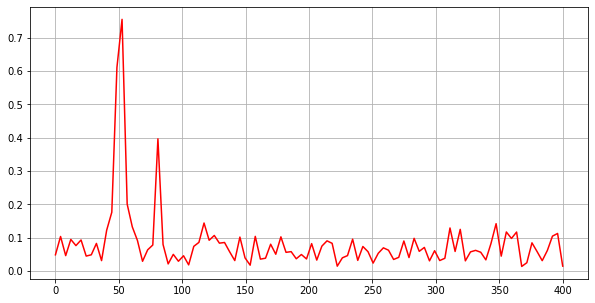

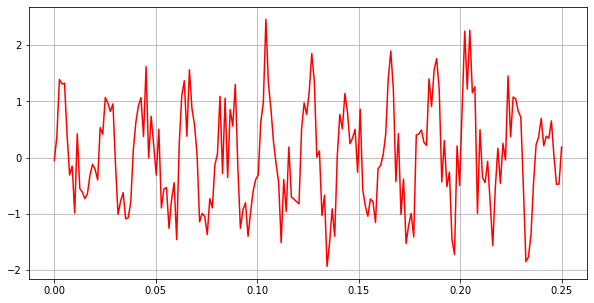

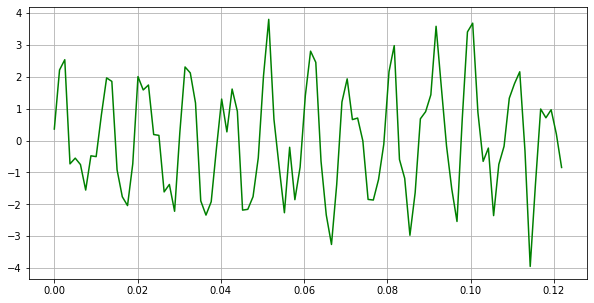

In [ ]:
from scipy.fft import fft, irfft
import numpy as np
# Number of sample points
N = 200
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
print(x.shape)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.5*np.random.normal(size=(N))
print(y.shape)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
xx = irfft(yf[:50])
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]),'r')
plt.grid()
plt.show()
plt.plot(x,y,'r')
plt.grid()
plt.show()
plt.plot(x[:98],xx,'g')
plt.grid()
plt.show()

(array([19]), array([0]))


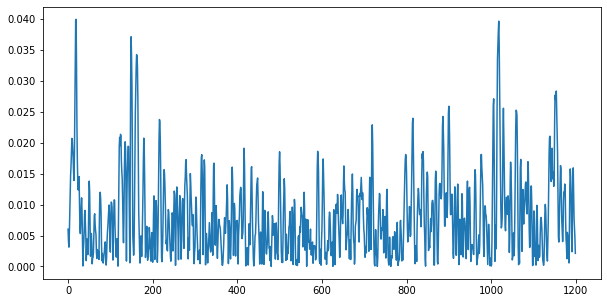

In [ ]:
data = pd.read_csv('normal.csv', header=1).values
yf = fft(data[:1200])
plt.plot(range(len(yf)),abs(yf))

# what is the highest amplitude (largest) value of frequency for this motor?
print(np.where(yf==max(yf)))

#Independent Component Analysis

In [ ]:
# Generate sample data
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

# Mix the Signals
S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

print("Signal Matrix : ", S.shape)
print("Mix Matrix : ", A.shape)
print("Transform Matrix: ", X.shape)
print("Mean of Transformed : ", X.mean())

Signal Matrix :  (2000, 3)
Mix Matrix :  (3, 3)
Transform Matrix:  (2000, 3)
Mean of Transformed :  0.23434201722279632


In [ ]:
ica = FastICA(n_components=3)
S_ica = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [ ]:
XX = np.zeros([1998,3])
XX[:,0] = X[:1998,0]
XX[:,1] = X[1:1999,0]
XX[:,2] = X[2:2000,0]
S_ica_single = ica.fit_transform(XX)  # Reconstruct signals
A_single = ica.mixing_ 

In [ ]:
# For comparison, compute PCA
pca = PCA(n_components=3)
S_pca = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

In [ ]:
print('Original Data Shape',S.shape)
print('Fast ICA Data Shape',S_ica.shape)
print('Single Channel Data Shape',S_ica_single.shape)
print('PCA Data Shape',S_pca.shape)

Original Data Shape (2000, 3)
Fast ICA Data Shape (2000, 3)
Single Channel Data Shape (1998, 3)
PCA Data Shape (2000, 3)


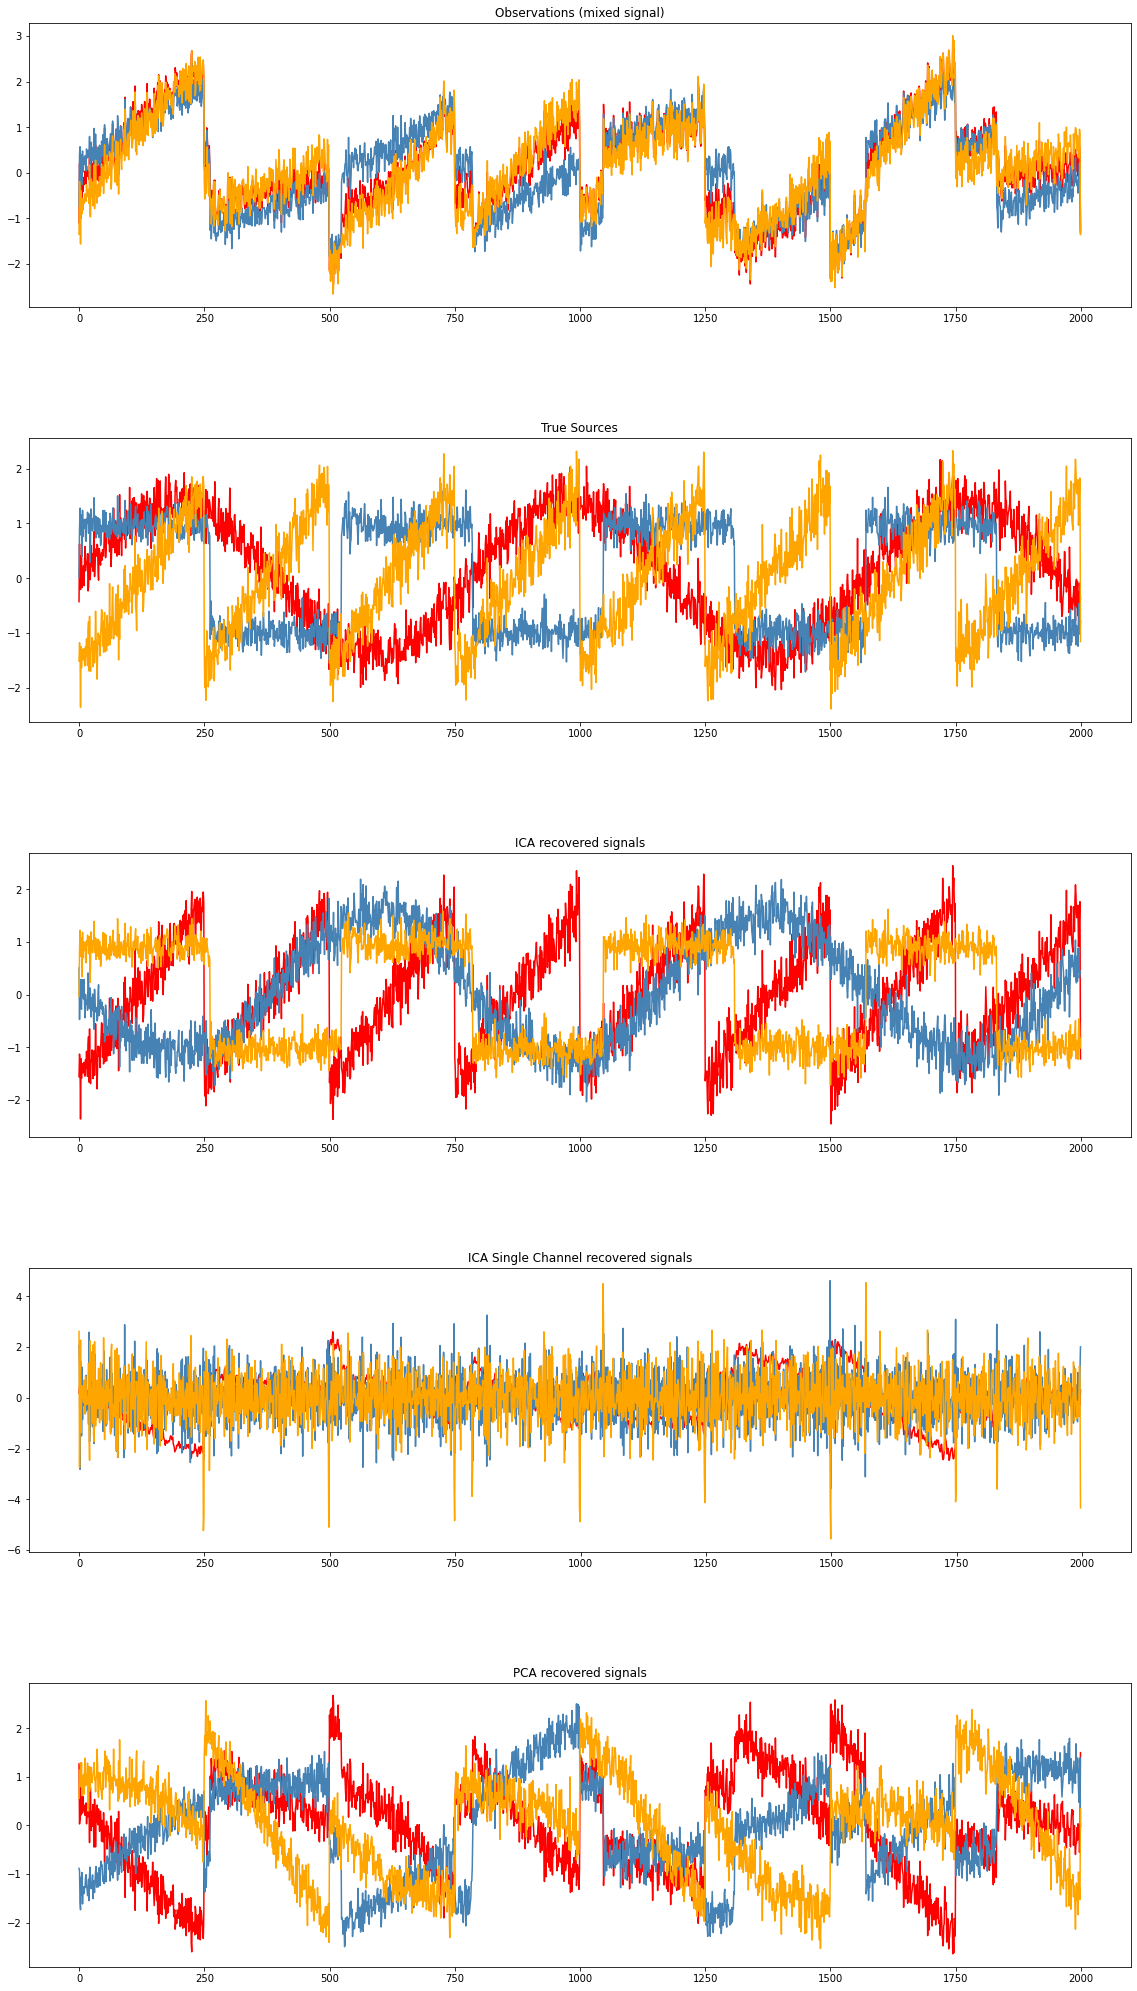

In [ ]:
plt.figure(figsize=(18,30))
models = [X, S, S_ica,S_ica_single, 
          S_pca]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'ICA Single Channel recovered signals',
         'PCA recovered signals',
        ]
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(5, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig/np.std(sig), color=color)
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

#Changepoints

     |████████████████████████████████| 706kB 6.0MB/s 


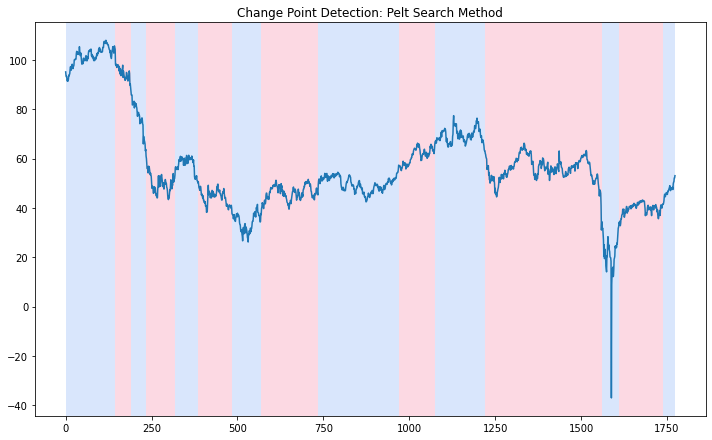

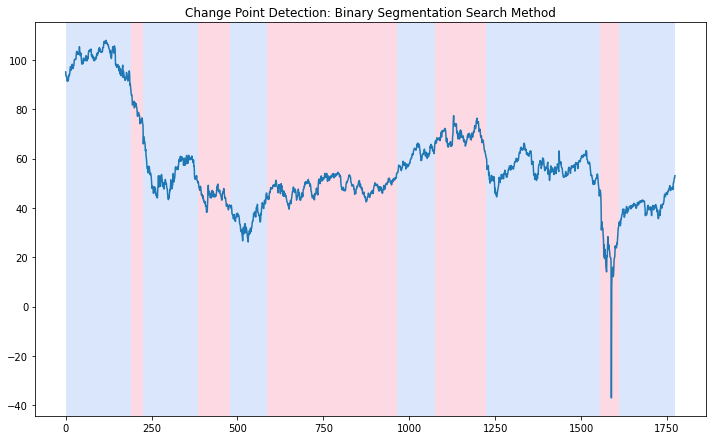

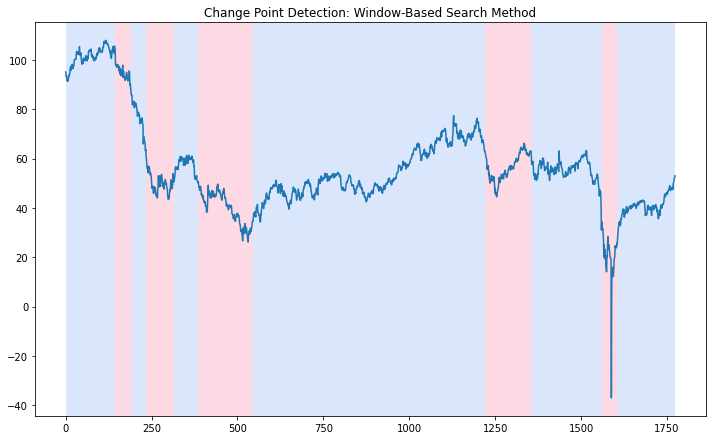

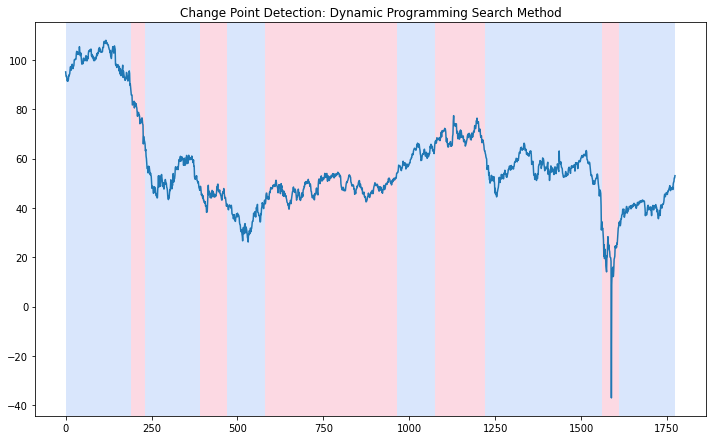

In [ ]:
!pip install EIA_python
import eia
import pandas as pd
!pip install RUPTURES
import ruptures as rpt
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    api: API that we're connected to
    series_ID: string. Name of the series that we want to pull from the EIA API
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df


"""
Execution in main block
"""

#Create EIA API using your specific API key
api_key = '8ef70d0269d0de3f3722d6cc0bd12bf9'
api = eia.API(api_key)
    
#Pull the oil WTI price data
series_ID='PET.RWTC.D'
price_df=retrieve_time_series(api, series_ID)
price_df.reset_index(level=0, inplace=True)
#Rename the columns for easier analysis
price_df.rename(columns={'index':'Date',
            price_df.columns[1]:'WTI_Price'}, 
            inplace=True)
#Format the 'Date' column 
price_df['Date']=price_df['Date'].astype(str).str[:-3]
#Convert the Date column into a date object
price_df['Date']=pd.to_datetime(price_df['Date'], format='%Y %m%d')
#Subset to only include data going back to 2014
price_df=price_df[(price_df['Date']>='2014-01-01')]

#Convert the time series values to a numpy 1D array
points=np.array(price_df['WTI_Price'])
    
#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
    
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()
    
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()
    
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

         Date       Open       High        Low      Close  Adj Close    Volume
0  2015-11-11  43.554001  43.896000  42.726002  43.816002  43.816002  16739000
1  2015-11-12  43.570000  43.799999  42.532001  42.588001  42.588001  14579500
2  2015-11-13  42.590000  42.598000  41.304001  41.438000  41.438000  17151500
3  2015-11-16  41.217999  42.995998  41.160000  42.862000  42.862000  14627000
4  2015-11-17  43.040001  43.200001  42.279999  42.799999  42.799999  10743500


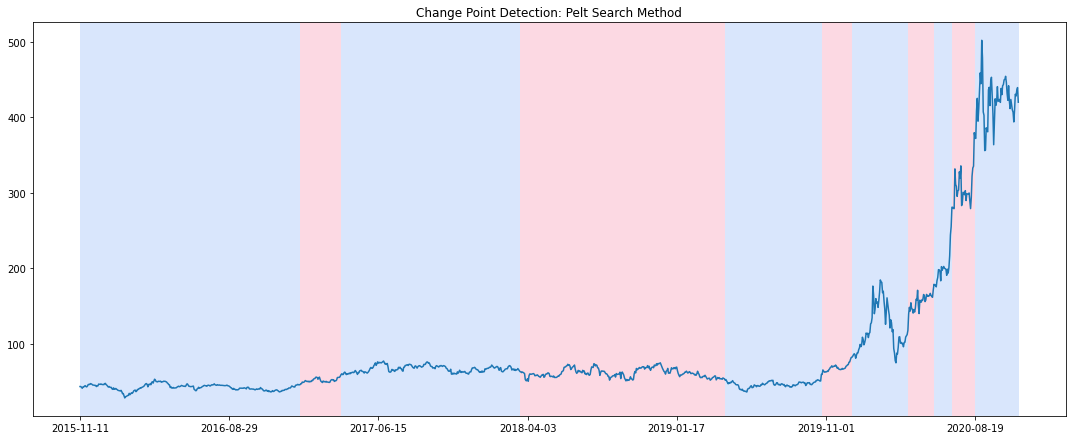

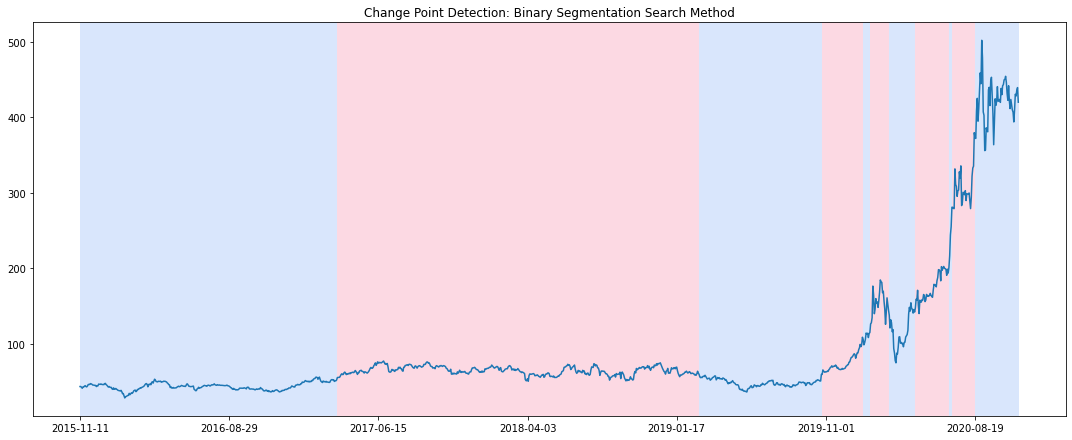

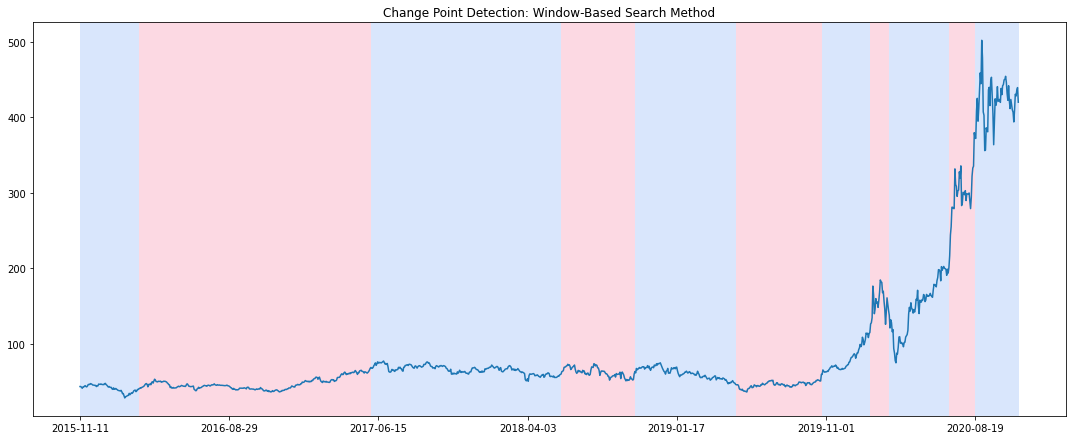

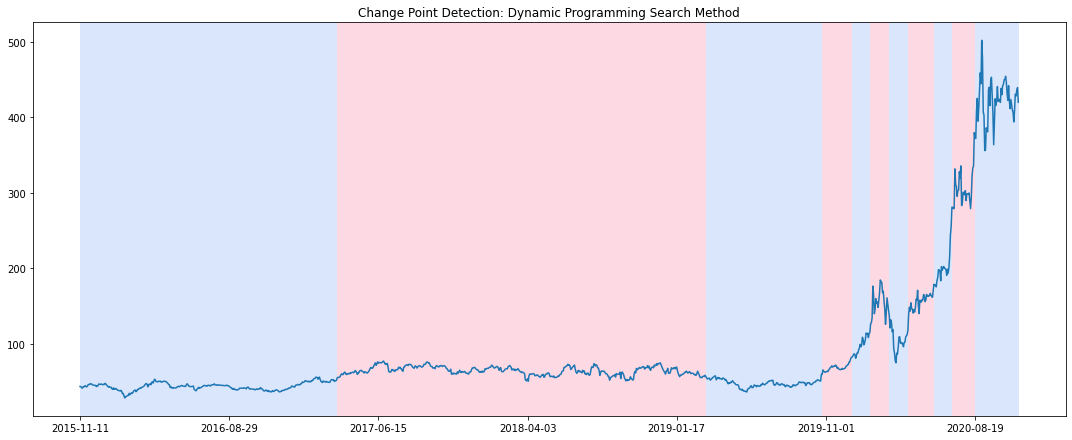

In [ ]:
tsla_df = pd.read_csv('TSLA (1).csv')
points=np.array(tsla_df['Open'])
print(tsla_df.head()) 

#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(15, 6))
plt.title('Change Point Detection: Pelt Search Method')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1],tsla_df['Date'][locs[1:-1]])
plt.show()  
    
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(15, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1],tsla_df['Date'][locs[1:-1]])
plt.show()

#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(15, 6))
plt.title('Change Point Detection: Window-Based Search Method')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1],tsla_df['Date'][locs[1:-1]])
plt.show()
    
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(15, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1],tsla_df['Date'][locs[1:-1]])
plt.show()

#Assessment